# Schéma de Lax-Friedrichs pour l'équation de Burgers

Nous considérons le problème posé sur un domaine périodique
$$
\left\lbrace\begin{aligned}
&\partial_t u + \partial_x \tfrac{1}{2}u^2 = 0, && t>0, 0\leq x\leq 1,\\
&u(0, x) = u^0(x), && 0\leq x\leq 1,\\
&u(t, 0) = u(t, 1), && t\geq 0.
\end{aligned}\right.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Le maillage

Le maillage en espace est constitué de $N$ points équi-répartis entre 0 et 1. Nous noterons
$$ x_j = h(j+1/2), \qquad 0\leq j< N,$$
avec $h=1/N$.

**Question**

> * Proposez une fonction `mesh` qui prend en argument un entier $N$ et qui retourne un `double` $h$ pour le pas du maillage et un `ndarray` de taille $N$ contenant les valeurs $x_j$ pour $0\leq j<N$.
> * Représentez le maillage obtenu avec $N=10$ en utilisant la commande `scatter`.

In [2]:
def mesh(N):
    """construit le maillage pour les différences finies"""
    m, h = np.linspace(0, 1, N, endpoint=False, retstep=True)
    m += .5*h
    return h, m

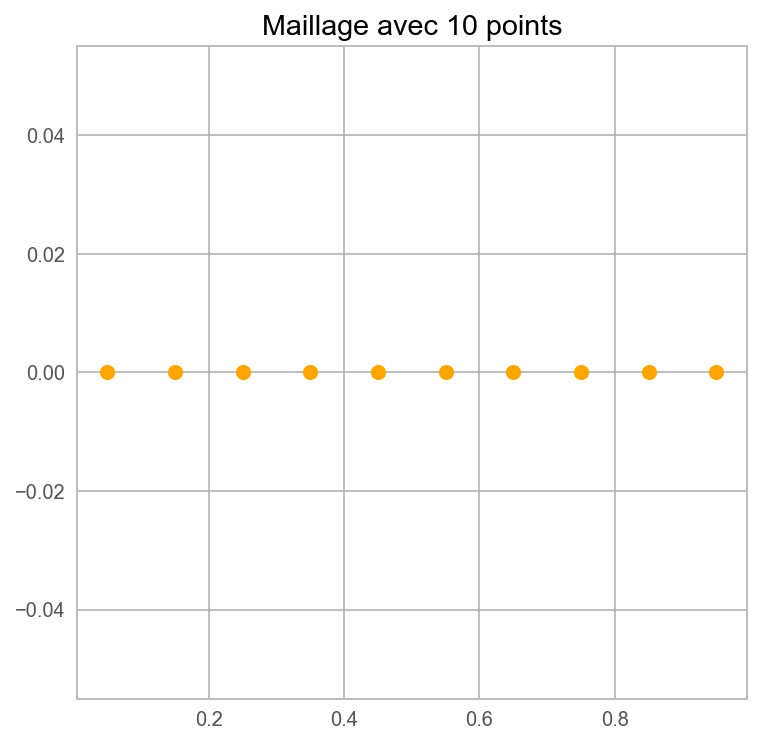

In [3]:
N = 10
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
h, m = mesh(N)
ax.scatter(m, np.zeros(m.shape), s=50, c='orange')
ax.set_title(f'Maillage avec {N} points');

## La donnée initiale

Pour fonction initiale $u^0$, nous souhaitons pouvoir tester le schéma avec différentes régularités (une fonction discontinue, continue, dérivable, $\ldots$).

**Question**

> * Proposez une fonction `init` qui prend en argument un `ndarray` $x$ et un `integer` $k$ et qui retourne un `ndarray` $y$ tel que $y_i=\phi^k(x_i)$ où $\phi^k$ est définie par
$$
\phi^k (x) = \boldsymbol{1}_{[x_l,x_r]}(x) P^{k+1}(x),
\quad
P(x) = \frac{4}{(x_r-x_l)^2} (x-x_l)(x_r-x),
$$
avec $x_l=1/4$ et $x_r=1/2$.
> * Tracez dans un même graphique les différentes données initiales pour $k\in\lbrace -1, 0, 1, 2\rbrace$.

In [4]:
def init(x, k):
    xl, xr = 0.25, 0.5
    y = 1. * (x>xl) * (x<xr)
    p = 4/(xr-xl)**2 * (x-xl)*(xr-x)
    for _ in range(k+1):
        y *= p
    return y

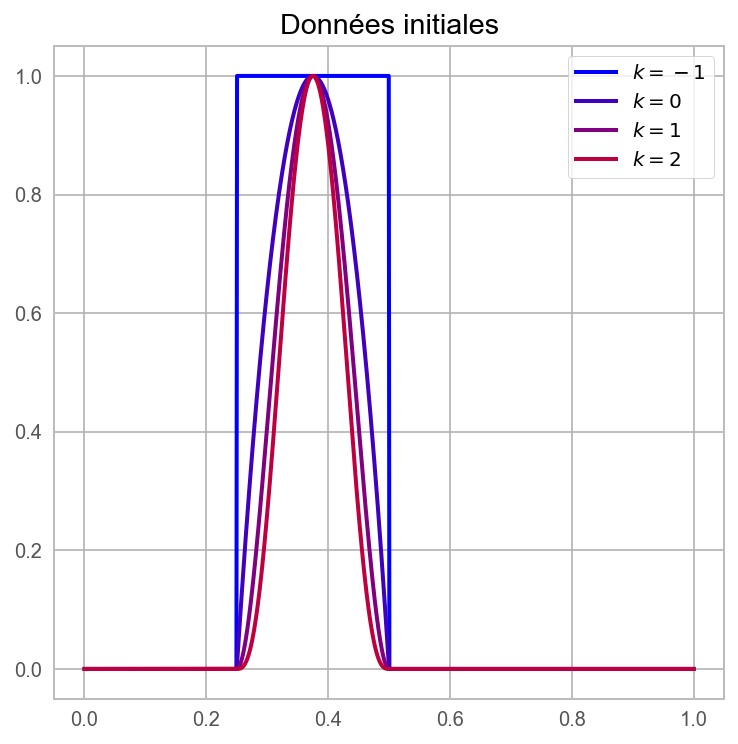

In [5]:
N = 1000
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
h, m = mesh(N)
liste_k = [-1, 0, 1, 2]
n = len(liste_k)
for i, k in enumerate(liste_k):
    ax.plot(m, init(m, k), color=(i/n, 0, 1-i/n), linewidth=2, label=f'$k={k}$')
ax.set_title(f'Données initiales')
ax.legend();

## Le schéma de Lax-Friedrichs

Nous allons à présent implémenter le schéma de Lax-Fridrichs défini par
$$
v_j^{n+1} = \frac{1}{2} (1+\beta_j^n) v_{j-1}^n + \frac{1}{2} (1-\beta_j^n) v_{j+1}^n,
$$
avec $\beta_j^n=.5(v_{j-1}^n+v_{j+1}^n) k/h$, où $k$ est le pas de temps et $h$ le pas d'espace.

**Question**

> * Proposez une fonction `lax_friedrichs` qui prend en argument un `ndarray` $v$, deux `double` $k$ et $h$ et qui retourne un `ndarray` $w$ calculé après un pas de temps du schéma de Lax-Friedrichs. Vous n'oublierez pas de traiter les termes de bord grâce à la condition de périodicité.
> * Testez le schéma proposé en traçant la solution approchée aux instants $t\in\lbrace 0, 0.1, 0.2, \ldots 1\rbrace$. Vous choisirez pour cela convenablement le paramètre $k$ en fonction de $h$. Faites varier la valeur de $k/h$ afin de mesurer l'impact de la condition CFL.

In [11]:
def lax_friedrichs(v, k, h):
    """un pas de temps du schéma de Lax-Friedrichs"""
    vp, vm = np.empty(v.shape), np.empty(v.shape)
    vp[:-1] = v[1:]
    vm[1:] = v[:-1]
    # conditions aux limites
    vp[-1] = v[0]
    vm[0] = v[-1]
    beta = .5*(vm+vp)*k/h
    a, b = .5*(1+beta), .5*(1-beta)
    return a*vm + b*vp

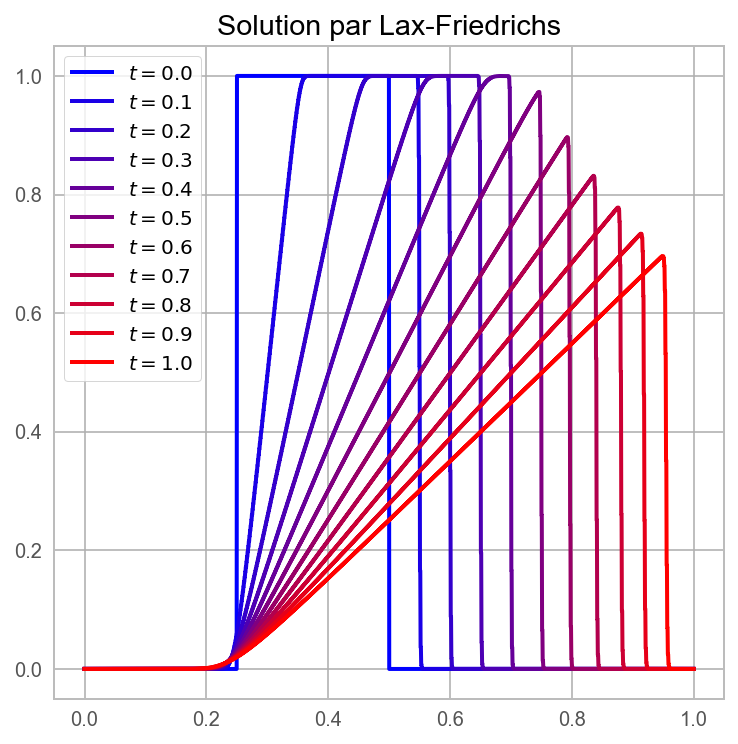

In [22]:
kk = -1  # paramètre de régularité
N = 2000  # nombre de points pour le maillage

h, m = mesh(N)  # maillage
k = .75*h           # pas de temps

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

t = 0.
v = init(m, kk)
for kt, Tf in enumerate([k/10 for k in range(11)]):
    while t < Tf:
        v = lax_friedrichs(v, k, h)
        t += k
    ax.plot(m, v, color=(kt/10, 0, 1-kt/10), linewidth=2, label=f'$t={t:3.1f}$')
ax.set_title(f'Solution par Lax-Friedrichs')
ax.legend();